In [1]:
# common
import os

# pip
import numpy as np
import pandas as pd
import xarray as xr

# maths
from sklearn.linear_model import LinearRegression

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# bluemath toolkit library
import sys
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

from sscode.data import Loader, load_dac_hindcast, load_codec_hindcast
from sscode.mda_rbf import MDA_RBF_Model
from sscode.pca import PCA_DynamicPred

In [2]:
linreg_stats = xr.open_dataset(
    '../data/statistics/stats_lm_regional_daily.nc'
)

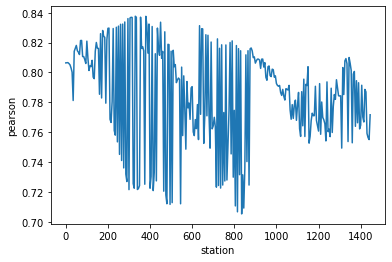

In [3]:
linreg_stats.pearson.plot()

In [4]:
linreg_stats

<xarray.Dataset>
Dimensions:    (station: 290)
Coordinates:
  * station    (station) int64 0 5 10 15 20 25 ... 1420 1425 1430 1435 1440 1445
Data variables:
    bias       (station) float64 ...
    si         (station) float64 ...
    rmse       (station) float64 ...
    pearson    (station) float64 ...
    spearman   (station) float64 ...
    rscore     (station) float64 ...
    latitude   (station) float64 ...
    longitude  (station) float64 ...

In [5]:
# load the data
loaded_data = Loader(
    data_to_load=['cfsr','moana','uhslc'], plot=False
)


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 




 lets calculate the PCs... 


 calculating the gradient of the sea-level-pressure fields... 


 pressure/gradient predictor both with shape: 
 (11354, 9, 8) 


 calculated PCs matrix with shape: 
 (11353, 144) 


 plotting 2 components with 2 EOFs + PC... 


 being the EOFs the slp, the gradient, in steps t, t-1 



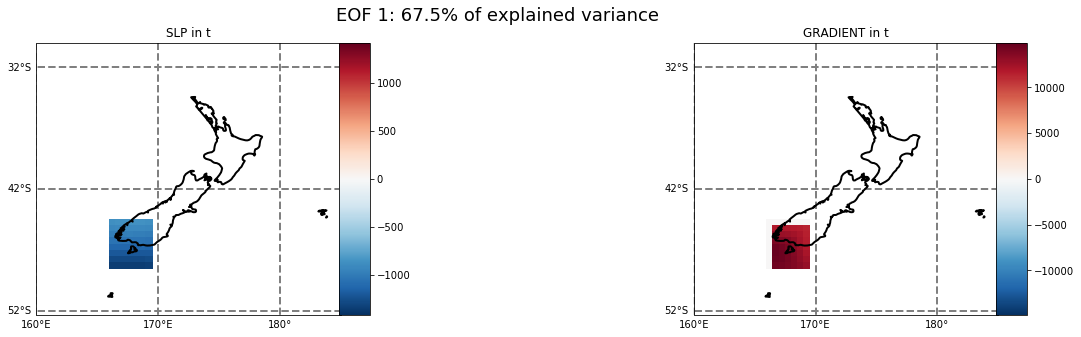

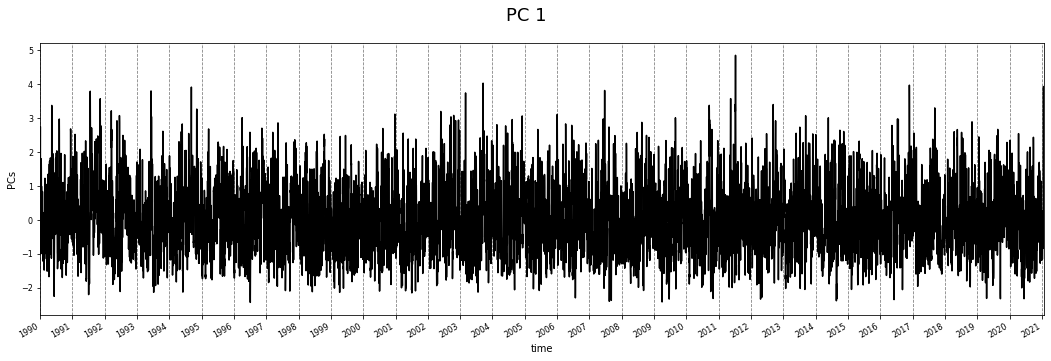

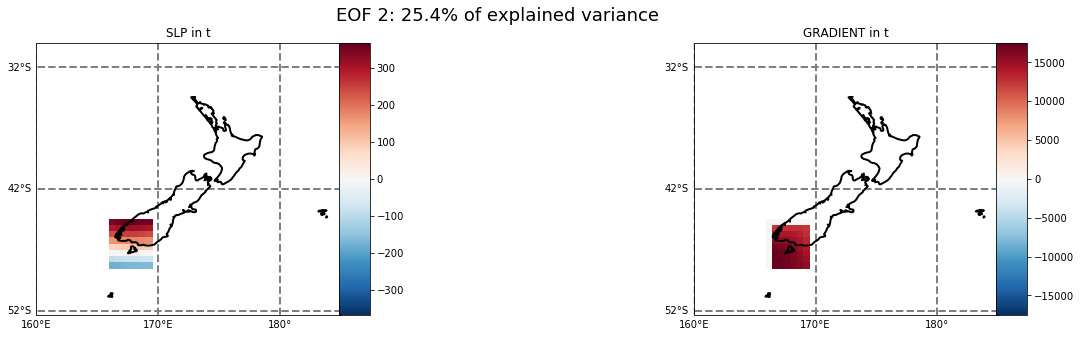

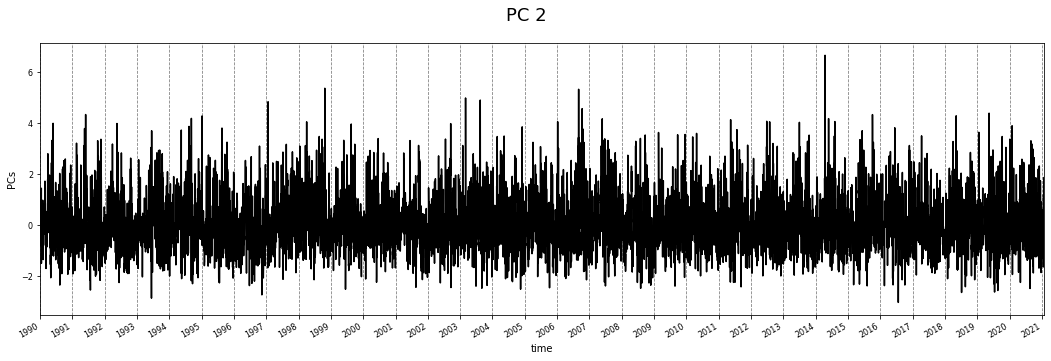

In [6]:
pcs_data, pcs_scaler = PCA_DynamicPred(
    loaded_data.predictor_slp, 
    calculate_gradient=True, time_lapse=1,
    region=(True,(
        167.7-2.1,
        167.7+2.1,
        -46.6+2.1,
        -46.6-2.1
    )),
    pca_plot=(True,True) # (plot,scale)
)

In [7]:
dac = load_dac_hindcast().isel(latitude=13,longitude=71).resample(time='1D').max().dropna(dim='time')


 loading the DAC hindcast data... 



In [8]:
codec = load_codec_hindcast().sel(name='Dog_Is').ss.resample(time='1D').max().dropna(dim='time')


 loading and plotting the CoDEC numerical data... 



In [9]:
moana = loaded_data.predictand.sel(site=100).ss.load()\
    .resample(time='1D').max().dropna(dim='time')


 MDA + RBF with 0.9999 per of pcs and 600 samples!! 



MDA: dataset 8109 centroids: 600/600



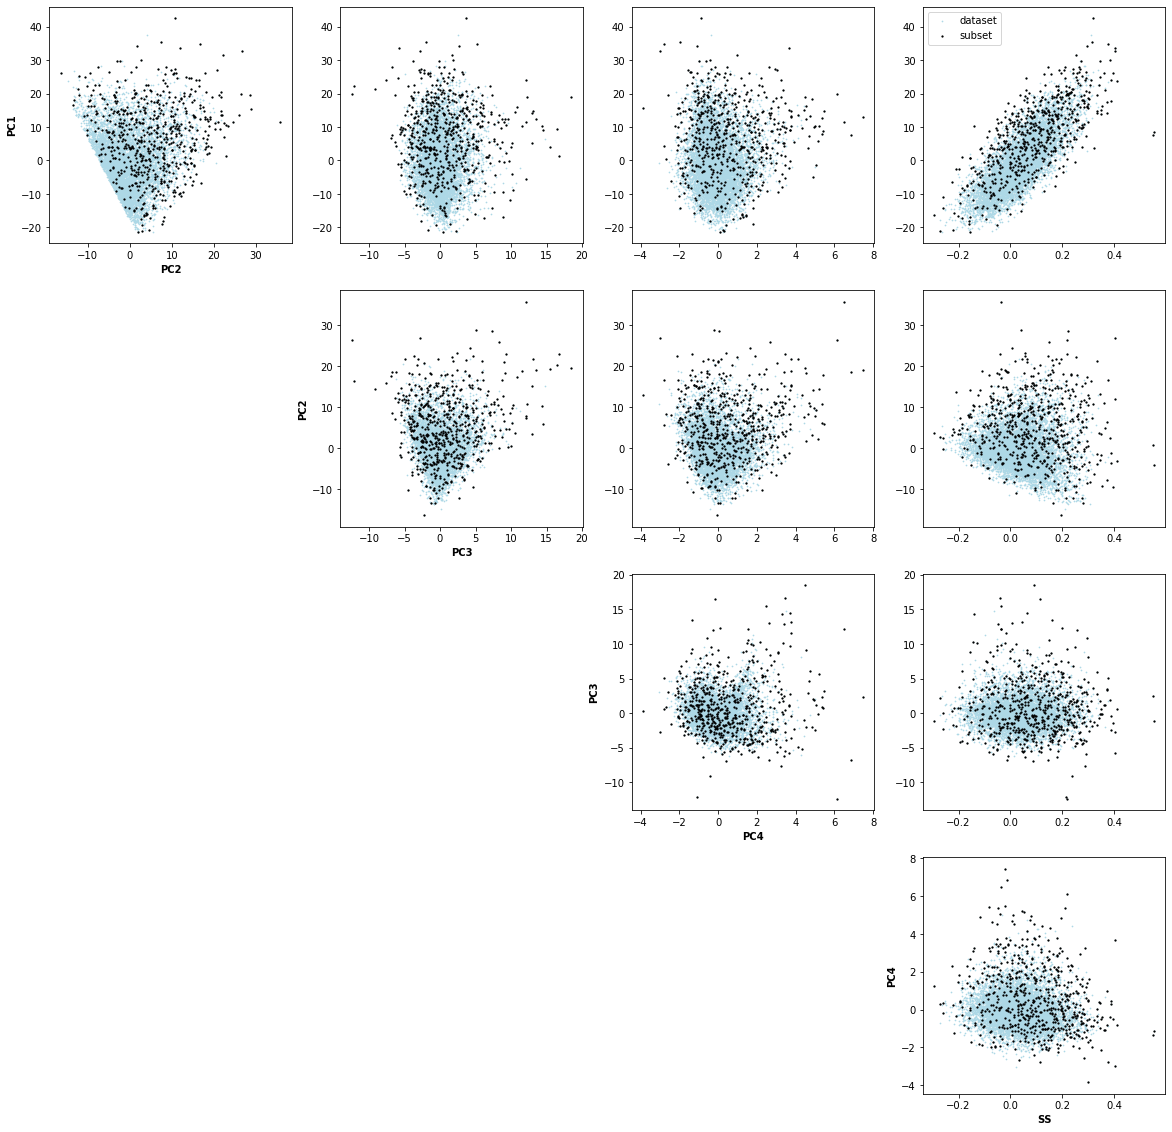

We finally have 609 points to interpolate with RBF
ix_scalar: 0,  optimization: 45.97 | interpolation: 0.60 | sigma: 0.5969


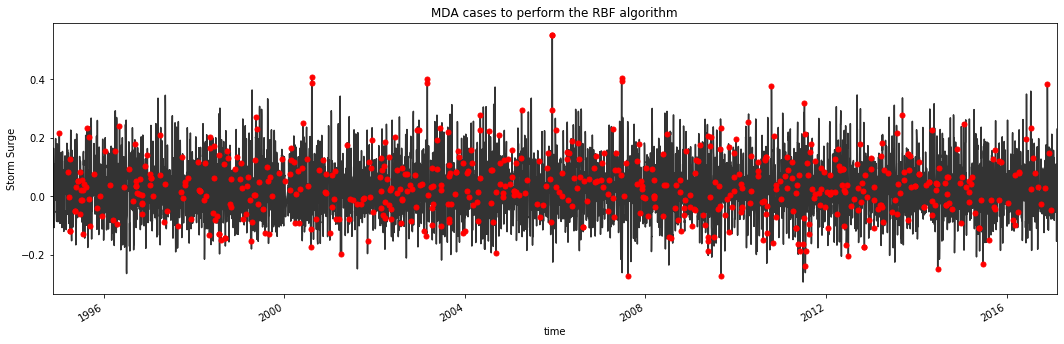

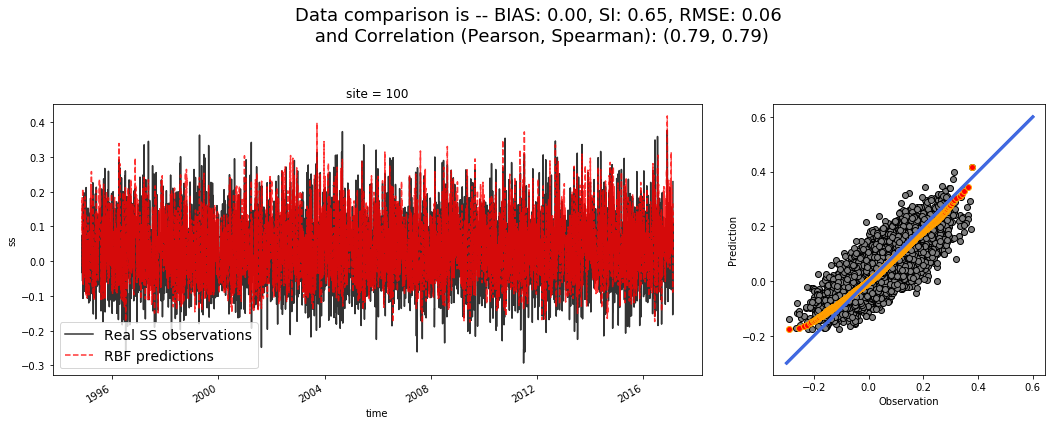

In [14]:
# perform the RBF interpolation, using MDA too
rbf_prediction = MDA_RBF_Model(
    pcs_data, moana,
    # xr.open_dataset('../data/cfsr/cfsr_regional_daily_pcs.nc'),
    # loaded_data.predictand.sel(site=100).load()\
    #     .ss.resample(time='1D').max().dropna(dim='time'),
    try_all=True, append_extremes=10,
    percentage_pcs_ini=[0.9999],
    num_samples_ini=[600]
)

In [ ]:
ss_data = loaded_data.predictand.sel(site=100).ss.load()\
    .resample(time='1D').max().dropna(dim='time')

In [ ]:
ss_data

In [ ]:
slp_data = loaded_data.predictor_slp.sel(time=ss_data.time)
slp_red_data = (slp_data - slp_data.mean(dim='time'))\
    .sel(
        longitude=slice(167.7-0.25,167.7+0.25),
        latitude=slice(-46.6+0.25,-46.6-0.25)
).isel(longitude=0,latitude=0)

In [ ]:
slp_red_data

In [ ]:
wind_data = loaded_data.predictor_wind.wind_proj_mask.sel(time=ss_data.time)
wind_red_data = wind_data.where(wind_data<10,-1)\
    .sel(
        lon=slice(167.7-0.25,167.7+0.25),
        lat=slice(-46.6+0.25,-46.6-0.25)
).isel(lon=0,lat=0)

In [ ]:
wind_red_data

In [ ]:
lin_model = LinearRegression(normalize=True).fit(
    np.concatenate(
        [slp_red_data.values.reshape(-1,1),
         wind_red_data.values.reshape(-1,1)],
        axis=1
    ), 
    ss_data.values.T
)

In [ ]:
lin_model.coef_

In [ ]:
plt.scatter(
    ss_data.values.reshape(-1),
    lin_model.predict(
        np.concatenate(
            [slp_red_data.values.reshape(-1,1),
             wind_red_data.values.reshape(-1,1)],
            axis=1
        )
    )
)
plt.axis('equal')

In [ ]:
lin_model.score(
    np.concatenate(
    [slp_red_data.values.reshape(-1,1),
     wind_red_data.values.reshape(-1,1)],
    axis=1
), ss_data.values.T
)